# When Prediction Fails
 
## When all you have is a Hammer...
Between 2015 and 2020, Machine Learning went through a massive surge. Its proven usefulness in the fields of computer vision and natural language understanding, coupled with an initial lack of professionals in the area, provided the perfect opportunity for a machine learning teaching industry. Figures like Andrew Ng and Sebastian Thrun managed to teach machine learning to the world at rock bottom prices. At the same time, on the software side, it became increasingly easier to fit a complex machine learning model (as you've already seen by the very few lines of code it took us to write an ML in the previous chapter). Tutorials about how to make intelligent systems sprung all over the internet. The cost of entry in ML plumend.

![img](./data/img/when-prediction-fails/ml-in-5.png)
 
Building ML became so simple that you didn't even need to know how to code very well (and I'm living evidence of that), nor the math behind the algorithms. In fact, you could build wonders with the following 5 lines of Python.
 
```python
X_train, y_train, X_test, y_test =  train_test_split(X, y)
 
## instantiate the machine learning model
model = MachineLearningModel()
 
## Fit the ML model
model.fit(X_train, y_train)
 
# Make predictions on unseen data
y_pred = model.predict(X_test)
 
# Evaluate the quality of predictions
print("Performance", metric(y_test, y_pred))
```
 
For the most part, this is an amazing thing! I'm all in for taking valuable content and making it available. However, there is also a dark side to all of this. This new wave of data scientists were trained mostly in predictive modeling, since that is what ML primarily focuses on solving. As a result, whenever those data scientists encountered a business problem, they tried to tackle it with, not surprisingly, predictive models. When they were indeed prediction problems, like the one we saw in the previous chapter, the data scientist usually succeeded and everyone got happy. However, there is an entire class of problems that are simply not solvable with prediction techniques. And when those appeared, the data scientists usually failed miserably. These are problems that are framed like "how much can I increase Y by changing X".
 
From my experience, this other type of problem is what management usually cares the most about. They often want to know how to increase sales, decrease cost or bring in more customers. Needless to say, they are not very happy when a data scientist comes up with an answer to how to predict sales instead of how to increase it. Sadly, when everything the data scientist knows is predictive models, this tends to happen a lot. As a boss of mine once told me: "when all you have is a hammer, everything starts to look like a thumb". 
 
Like I've said, I'm all in for lowering the cost of knowledge, but the current Data Scientist curriculum has a huge gap. I think that my job here is to fill in that gap. Is to equip you with tools to solve this other class of problems, which are causal in nature. 

What you are trying to do is estimate how something you can control (advertisement, price, customer service) affects or causes something you want to change, but can't control directly (sales, number of customers, PNL). But ,before showing you how to solve these problems, I want to show you what happens when you treat them like prediction tasks and try to solve them with the traditional ML toolkit. The reason for it is that data scientists often come to me and say "OK, but although tackling causal problems with prediction tools is not the best idea, it surely helps something, no? Imean, it couldn't hurt...". Well, as it turns out, it can. And you better understand this before you go on hammering your own thumb.

![img](./data/img/when-prediction-fails/horse-meme.png)


In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

# helper functions for this notebook
from nb18 import ltv_with_coupons

## Who Wants a Coupon?
 
To make matters more relatable, let's continue with the example we used in the previous chapter, but with a little twist to it. Before, we were trying to distinguish the profitable from the non profitable customers. We framed that as a prediction problem: predicting customer profitability. We could then build a machine learning model for this task and use it to choose who we would do business with: only the customers we predicted to be profitable. In other words, our goal was to separate the profitable from the non-profitable, which we could do with a predictive model.
 
Now, you have a new task. You suspect that giving coupons to new customers increases their engagement with your business and makes them more profitable in the long run. That is, they spend more and for a longer period. Your new assignment is to figure out how much the coupon value should be (zero included). Notice that, with coupons, you are essentially giving away money for people to spend on your business. For this reason, they enter as a cost in your book account. Notice that if the coupon value is too high, you will probably lose money, since customers will buy all they need using only the coupons. That's another way of saying that they will get your product for free. On the flip side, if coupon value is too low (or zero), you are not even giving coupons. This could be a valid answer, but it could also be that some discounts upfront, in the form of coupons, will be more profitable in the long run. 
 
For reasons you will see later, we will use a data generating function instead of loading a static dataset. The function `ltv_with_coupons` generates transaction data for us. As you can see, they have the same format as the one we saw previously, with one row per customer, a column for the cost of acquisition and columns for the transactions between day 1 and 30. 

In [2]:
transactions, customer_features = ltv_with_coupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,5,0,2,2,...,0,3,0,4,0,0,0,0,0,0
1,1,-61,2,0,5,2,3,4,1,0,...,5,0,1,35,11,0,5,2,4,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


As for the other parts of the data, again, we have a customer identifier, the region the customer lives, the customer income and the customer age. In addition, we now have a variable that is `coupons`, which tells us how much we've given in coupons for that customer.

In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,18,1025,5,24
1,1,40,1649,5,26
2,2,35,2034,15,33
3,3,29,1859,15,35
4,4,11,1243,5,26


To process this data to a single dataframe, we will sum all the columns in the first table (that is, summing `CACQ` with the transactions).This will give us the `net_value` as it was computed in the previous chapter. After that, we will join in the features data and update the `net_value` to include the coupon cost.

In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            # join net_value and features
            .merge(profitable, on="customer_id")
            # include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,15,33,-23
3,3,29,1859,15,35,-45
4,4,11,1243,5,26,-26


This processed data frame has all that we need. It has our target variable `net_value`, it has our customer features `region`, `income` and `age`, and it has the lever or treatment we want to optimise for: coupons. Just to begin understanding how coupons can increase `net_value`, let's look at how they were given away.

In [5]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

We can see that most of the coupons that were handed out had a value of 5 BRL, followed by the coupons with 10 BRL in value. We gave very few 15 BRL coupons or no coupons at all (zero value). This is indicative that they were **NOT** given randomly. To check that, let's see the correlation between the other variable and coupons.

In [6]:
customer_features.corr()[["coupons"]]

,coupons
customer_id,0.002239
region,-0.004073
income,0.001236
coupons,1.000000
age,0.897308
net_value,-0.078369


That's interesting. It looks like the older the person, the higher the probability he or she will receive a coupon. This is some indication of bias in our data. We can also see a negative correlation between coupons and `net_value`: the more coupons we give, the smaller the net_value. This is hardly causal, since we already know that coupons were not randomly distributed. It could be that, say, older people spend less on our products and also receive higher coupon values, confounding the relationship between coupons and `net_value` to the point of making it negative.

The point being, we know there is bias. However, since there is already too much packed into this chapter, I'll ignore it for now (actually, I'll bypass the problem with an artifact you will see in just a moment). Just keep in mind it's something we will have to address sometime in the future.

At this point in the analysis, **if this was a prediction problem**, we would probably split the dataset into a training and a test set to build and evaluate some policies, respectively. But this is NOT a prediction problem. The final goal here is not to get a good prediction on customer profitability. Instead, it's to figure out the optimal coupon strategy. To evaluate this optimization, we would have to know how things would have played out if we have given different coupons than the ones that were given. This is the sort of counterfactual "what if'' question we've been studying under causality. Cross validation won't help us here because we simply can't observe counterfactuals. We can only see what happened for the coupons that were actually given, but we can't know what would have happened if customers received a different coupon value. Unless, we have simulated data!

If our data is simulated, we can generate the exact same data, only changing the coupon value parameters. This will allow us to see how `net_value` changes under different coupons strategies. We will then be able to calculate the treatment effect between different strategies \\(NetValue_{t=a} - NetValue_{t=b}\\). With the power of simulated data, understanding this chapter will be much easier. Oh yes, and this will also render the bias problem irrelevant, because we will observe the causal effect directly. 

Nevertheless, always remember that this is a pedagogical artifact. In the real world, you don't have simulated data and you certainly can't see what would have happened under different treatment strategies. Individual causal effects remain hidden as they always have been. This poses an interesting problem. How can we evaluate our strategies for identifying causal effect if we can never see the actual causal effect? The real answer is very involved and so important that it deserves its own chapter. Rest assured that we will tackle it. For now, just enjoy the simplicity of simulated data. And speaking of simplicity...


## Simple Policy

As always, the first thing we should do whenever we encounter a new data problem is to ask ourselves "what is the simplest thing I can do that will already bring value?". For this specific case, the simplest thing is to look back on the data that we have and estimate the `net_value` for each coupon value. Then, check which coupon value is generating the highest `net_value` and give only that coupon value for every customer. 

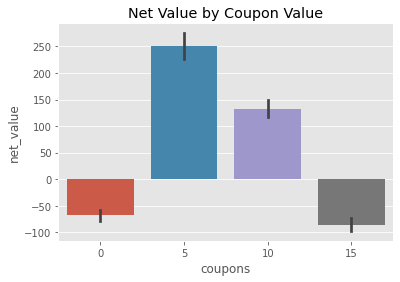

In [7]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value");

Doing that analysis, we can see that, on average, we lose money when the coupon value is 0 or 15 and we gain money for coupons of 5 and 10 BLR. The highest average `net_income` appears when we have 5 BLR coupons, yielding us about 250 BLR in `net_value` per customer. Naturally then, the simplest thing we can try is to give everyone 5 BLR in coupons and see how that would play out. This completely disregards the possibility of bias but hey, we are talking simplicity here!

To do evaluate that policy, the function `ltv_with_coupons` accepts as argument a 10000 array that contains the desired coupon for each of the 10000 customers on our database. To create this array, we will generate an array of ones with `np.ones` the size of our `coupons` array (10000) and multiply it by 5. Then, we will pass this array to the `ltv_with_coupons`. This will generate a new dataset exactly like the one we had previously, but with every coupon value set to 5. We then process this data to get the net value under this newly proposed policy.

In [8]:
simple_policy = 5 * np.ones(customer_features["coupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)
customer_features_simple_policy = process_data(transactions_simple_policy, customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,5,33,63
3,3,29,1859,5,35,63
4,4,11,1243,5,26,-26


Just as a sanity check, let's see if the features are indeed unchanged, considering the first few customers. Take the third one, for example (`customer_id` 2). For this customer, the region is 35, income is 2034 and the age is 33. If we scroll up a bit, we can see that it matches what we had before, so we are good here. Also, we can check that all the coupons are indeed 5 BRL. Finally, the `net_value` changes as expected. One reason for this is that the cost associated with coupons will change. For example, that customer had 15 BRL in coupons, but now it's 5. This would decrease the cost from 15 to 5 units. But notice that the `net_value` goes from -23 to 63, a 86 BRL increase in `net_value`. This is much larger than the 10 cost difference. Here giving less in the coupons made this particular customer much more profitable than he or she was before. Finally, to evaluate the policy, we can simply take the average `net_value`.

In [9]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

252.9268

As we can see, this simple policy is telling us we can get, on average, 253 BRL for each customer if we give them all a 5 BLR coupon. This is massive! But can we do better? What if we use our shiny machine learning hammer on this problem? Let's try this next.


## Policy With Model

To use ML, we will adapt what we did in the previous chapter. The idea is to build a ML model that predicts `net_value`, just like before, take those predictions and bins them into a defined number of bands. Then, we will partition the data into those bands. Essentially, we are splitting the customer by their predicted `net_value`. Customers that we think will generate roughly the same `net_value` will end up in the same bin or group. Finally, for each group, we will see which coupon value yields the maximum `net_value`. We are doing the same thing as in the simple policy, but now within the groups defined by a prediction band.

![img](./data/img/when-prediction-fails/partitions.png)

The intuition behind this is the following: we know that, on average, 5 BLR coupons performed better. However, it is possible that for some group of customers, another value is even better than 5 BRL. Maybe 5 BLR is the optimal strategy for most of the customers, but not for all of them. 

![img](./data/img/when-prediction-fails/personalise.png)

If we can identify the ones where the optimal value is different, we can build a coupon strategy better than the simple one we did above.

This is what we call a personalisation problem. We can leverage personalisation when we have more than one strategy to choose from and at least one of them is not the overall best strategy, but it is the best in a subset of the targeted population. This definition is a bit convoluted, but the intuition is simple. If you have only one strategy, you are not personalising. You are doing the same thing for every customer. If you have more than one strategy, but one of them is better for every single customer, why will you personalise? You could just do that one best thing. You will only do personalisation if you have one strategy that works better at one subset of the population and another strategy that works best in another subset of the population.

But back to the example. The first thing we need is a function that fits our predictive model and also splits the predictions into the prediction bands. This function will return another function, a prediction function that will take a dataframe and add both predictions and band columns.


In [10]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])
        
        # discretize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False) 
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))
    
    return predict

To evaluate the quality of our predictions, we will split the dataset into a training and a testing set. Notice here that we are evaluating the quality of the prediction, NOT of the policy. This is just to see if our model is any good at doing what is supposed to do. 

In [11]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

Now, let's train our model and make 10 bands with its predictions.

In [12]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(1)
model = model_bands(train, features, target, model_params, n_bands=10)

After training our model, we can use it to make predictions, passing it a dataframe. The result will also be a dataframe with 2 new columns: `predictions` and `pred_bands`.

In [13]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,30,567,5,27,-129,-16.296297,2
5910,5910,32,647,5,25,-55,-16.296297,2
1950,1950,31,2953,15,33,-142,102.237797,7
2119,2119,1,2860,5,27,-23,94.291197,7
5947,5947,49,589,5,26,-91,-3.525593,3


To see the predictive power of our model, we can look at the \\(R^2\\) for both training and test sets.

In [14]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.5382953634651921
Test Score:,  0.504563847410434


Remember that this performance is only the predictive performance. What we really want to know is if this model can make us some money. Let's make a policy! The idea here is very similar to what we saw in the previous chapter. We will group the customers by model band. Then, for each type of customer (where type is defined by the bands) we'll see which decision - coupon value in our case - is the best one. To do so, we can group our data by prediction band and coupon value and plot the `net_value`.

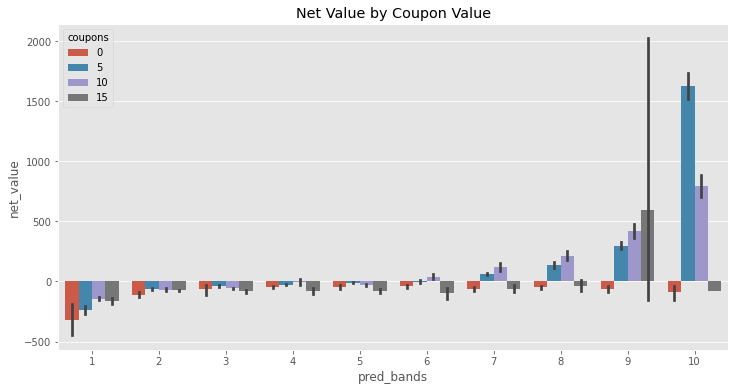

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value");

This plot is very interesting. Notice how the optimal decision changes across prediction bands. For instance, on bands like 1, 7 and 8, the best thing to do is to give 10 BLR in coupons. For bands like 3, 5 and 10, the best thing is 5 BRL in coupons. This means that this policy is very much like the simple one, except for the last band. This is evidence that personalisation might be possible, since the optimal decision changes across subpopulations.

We can code that policy with a couple of `if ... then ...` statements, but I'll show a more general approach that leverages dataframe operations.

![img](./data/img/when-prediction-fails/pandas-magic.png)

First, we will group our customers by band and coupon value and take the average `net_value` for each group, much like the plot above.

In [16]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "coupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-324.538462
1,1,5,-237.683871
2,1,10,-142.203390
3,1,15,-160.413223
4,2,0,-108.980769
5,2,5,-63.718650
6,2,10,-68.327146


Then, we will group by band and take the `net_value` rank for each row. This will order the rows according to the average `net_value`, where 1 is the best `net_value` in that band.

In [17]:
pred_bands["max_net"] = (pred_bands
                         .groupby(['pred_bands'])
                         [["net_value"]]
                         .rank(ascending=False))


pred_bands.head(7)

,pred_bands,coupons,net_value,max_net
0,1,0,-324.538462,4.0
1,1,5,-237.683871,3.0
2,1,10,-142.203390,1.0
3,1,15,-160.413223,2.0
4,2,0,-108.980769,4.0
5,2,5,-63.718650,1.0
6,2,10,-68.327146,2.0


For example, for band one, the best coupon strategy is 10 BRL. Next, we will keep only the greatest `net_value` per band.

In [18]:
best_coupons_per_band = pred_bands.query("max_net==1")[["pred_bands", "coupons"]]

best_coupons_per_band

,pred_bands,coupons
2,1,10
5,2,5
9,3,5
14,4,10
17,5,5
22,6,10
26,7,10
30,8,10
35,9,15
37,10,5


To build our policy, we will take that small table above and join it back on the original table using the band as the key. This will pair each row in the original dataset with what we think is optimal coupon value, according to this policy. Then, we sort the rows according to the `customer_id` so that we keep the same ordering we had previously. This is important for evaluation, since `ltv_with_coupons` takes as argument the coupon value in the order of the original dataframe.

In [19]:
coupons_per_id = (model(customer_features)
                 .drop(columns=["coupons"])
                 .merge(best_coupons_per_band, on="pred_bands")
                 [["customer_id", "coupons"]]
                 .sort_values('customer_id'))

coupons_per_id.head()

,customer_id,coupons
0,0,10
1,1,10
788,2,5
1982,3,10
2743,4,5


Finally, to evaluate the policy, we pass the `coupons` column as the coupon array to the `ltv_with_coupons` function. This will regenerate the data, now assuming the coupons were given as we defined by this policy. 

In [20]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model, customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,10,24,-87
1,1,40,1649,10,26,42
2,2,35,2034,5,33,63
3,3,29,1859,10,35,-40
4,4,11,1243,5,26,-26


Just doing a sanity check again, we can see that the third customer is still the one with region 35, income 2034 and age 33. It also has a coupon value of 5 BRL, just like we've established by our policy. 

To check how much money this policy is making us, we can compute the average `net_value` mean for this new dataset.

In [21]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

229.9341

Not bad! We can expect to get about 230 BRL per customer with this model policy. But wait a second! You remember how much we were making with the simple policy? Let's compare both of them side by side.

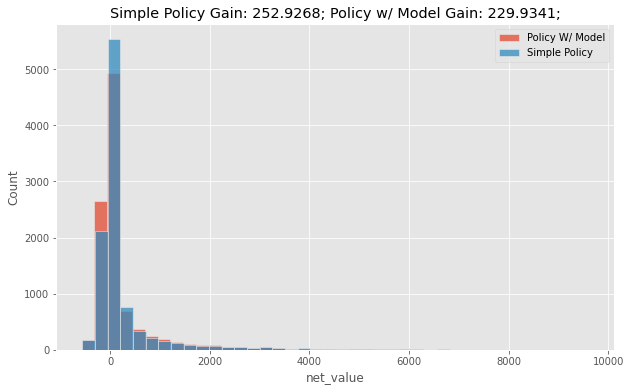

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");

Here is where most Data Scientists fall off their chair. The policy with the model has an average `net_income` which is 20 BRL worse than a very simple policy. How can a model that is good at predicting `net_value` not be good for a strategy that aims to maximize `net_value`? Surely, there must be some bug in the code. You are clearly mistaken. This cannot be! Well, as it turns out, there is a perfectly reasonable and simple explanation for it. However, the answer to this question is so important that I think it's worth going a bit deeper into it.

## Hammering Your Thumb with Predictions

The short answer lies in understanding what we want with this policy, namely, to optimize `net_value` by playing with the coupon values. If we were to put it in an image, it's not crazy to think that `net_value` will have a quadratic shape on coupons: as we increase the coupon value `net_value` first increases, then it reaches a maximum point. After that, any additional coupon value will cost more than the value it brings.

![img](./data/img/when-prediction-fails/opt-deriv.png)

Finding the optimal coupon value is then equivalent to finding the maximum of the `net_value` function. We can do this by differentiating the function and setting it to zero (second plot). Economists might recognize this as a pricing problem.  The way they (we) would tackle this problem would be to assume a functional form for `net_value`, differentiate it and optimize it. 

There are some great merits to this approach, but I feel is not that general and it requires a great deal of hypothesizing. Sadly, real world data doesn't come with an underlying function we can differentiate, so guesswork is often involved here. A more practical approach (and perhaps less elegant) is to test multiple coupon values and see which one yields the best `net_value`. This is exactly what our simple policy does. It looks at what happened in the past and repeats what the treatment that was shown to be the most promising one. 

Contrast this to what the model based policy does. First, the model based policy fits a machine learning model to predict `net_value`. Then, it partitions the customer space according to the predictions. If the model is good, this is approximately equal to partitioning the space by `net_value` itself, just like in the following plot.

![img](./data/img/when-prediction-fails/model-opt.png)

The better the prediction, the more this partitioning of the space approaches partitioning on the target variable, `net_income`. Pay very close attention to what happens when you do that. Essentially, you are splitting the customer into sets where `net_value`, the thing you've predicted, doesn't change! And that makes total sense from a predictive standpoint. If your model is good at predicting, groups of points that have the same prediction will also have the same `net_value`. 

So far, so good, but look at what this does to the perceived function of `net_value` on coupons (green lines). It flattens them to have no slope at all. From the predictive point of view, this is awesome. It means that your model has captured all the variation in `net_income`. However, from the policy perspective, this is terrible, because there is no variance left in `net_income` for us to see how it would change given different coupon values. Without this variation in `net_income`, it would look like changing the coupon values has no effect on `net_income` at all, leaving us no room for optimization. By the way, this is a general phenomenon that has nothing to do with the specific quadratic shape we are using here. I'm only using an example to make things more concrete.

To summarize it, whenever we want to optimise some \\(Y\\) variable using some \\(T\\) variable, predicting \\(Y\\) will not only not help, it will hurt our policy, since data partitions defined by the prediction will have limited \\(Y\\) variance, hindering our capacity to estimate how \\(T\\) changes \\(Y\\), that is, the elasticity \\(\frac{\delta Y}{\delta T} \\). This is the most important paragraph of this chapter. All of it is summarized here, so reread it if you didn't understood at first. 

The key to fixing this mistake lies in adjusting our objective to what we really want. Instead of estimating \\(Y\\) out of \\(X\\), which is what prediction does, we need to estimate \\(\frac{\delta Y}{\delta T} \\) out of \\(X\\). Easier said than done. As you might have guessed already, this precisely what causal inference is all about. And, as it is natural of causal problems, we can't observe our quantity of interest \\(\frac{\delta Y}{\delta T} \\). You simply cannot observe how `net_income` would change if we changed the coupon value because we only observe one instance of a coupon per customer. We can never know what would have happened if some different coupon value had taken place (unless we use simulated data, of course. But that's only useful for teaching purposes).

This characteristic of causal problems leads to further questions: how can I know if my model is any good if I can't see what it is supposedly estimating? How can I validate a model like that? Besides, what do we do when data is not random? How can we estimate the best policy under biased data? Those are fair questions and we shall answer them in time. Meanwhile, keep in mind that, as we change our focus from estimating \\(Y\\) to estimating \\(\frac{\delta Y}{\delta T}\\), lots of things will have to change accordingly. The traditional ML toolkit will need some adaptation.


## When Might Prediction Helps

All this mess with machine learning hindering our ability to infer causal effects comes from mistaking the real goal. It comes from estimating \\(Y\\) instead of \\(\frac{\delta Y}{\delta T} \\). But sometimes, you might actually get away when using a prediction model to achieve a causal inference goal. But for this to happen, \\(Y\\) and \\(\frac{\delta Y}{\delta T} \\) must be somehow correlated. For example, consider the cases on the image below.


![img](./data/img/when-prediction-fails/waiting-time.png)

The first one is the problem we've seen before of understanding how coupons impact profitability. First, as we increase coupon value, profitability increases. If they go up together, we can see that they are positively correlated. Moreover, in the derivative plot, at the beginning, as we increase the coupon value, the elasticity \\(\frac{\delta Y}{\delta T} \\) decreases. If we put both of them together, in the first region of the plot, as net value increases, elasticity will decrease. This means that they are negatively correlated.

But that's only at the beginning. If we keep increasing the coupon value, profitability will decrease and elasticity profitability will also decrease. This means that \\(\frac{\delta Y}{\delta T} \\) and \\(Y\\) are now positively correlated. So, while outcome and elasticity are negatively correlated at the beginning, this correlation reverses as we increase coupon values. This means that a prediction model won't help us here because there isn't a direct relationship between outcome and elasticity of the outcome. 

Another way of thinking about this is that prediction models make slices of the data on the \\(Y\\) axis. If we do those sorts of slices, we will mix units that are both in the positive elasticity region and in the negative elasticity region. 


![img](./data/img/when-prediction-fails/slice-1.png)

Now, consider a second case where we want to see how waiting in line to get answered by customers services impact customer satisfaction. In this case, we can see that customer satisfaction drops pretty fast in the first few minutes of waiting time. Customers get really pissed off when they go from not having to wait much to having to wait just a little bit. However, as waiting time increases, customer satisfaction is already so low it doesn't drop much afterwards. It sorts of saturates at a lower level. 

This case is interesting because the relationship between \\(\frac{\delta Y}{\delta T} \\) and \\(Y\\) doesn't change much. It is always negatively correlated. As waiting time increases, satisfaction decreases and satisfaction elasticity increases. Or, as \\(T\\) increases, \\(\frac{\delta Y}{\delta T} \\) also increases and  \\(Y\\) decreases. In this case, a prediction model can be useful. The reason being that, now, if we slice on the \\(Y\\) axis, we will group units that have similar elasticities.  

![img](./data/img/when-prediction-fails/slice-2.png)

More generally, whenever we have these sorts of functional forms where elasticity changes ruthly in the same direction as the outcome, you might get away with prediction models. Now, be careful here. This doesn't mean they are your best bet nor that you should use them for causal problems. I'm simply stating this here so that when you come across a prediction model that works for a causal goal, you can understand what is happening. 


## Key Ideas 

We saw how there is a whole range of problems that are not solvable with traditional, predictive Machine Learning. Those problems are optimization ones, with a causal component, usually framed as "how should I set this thing I can control, T (price, number of phone calls, discount, ...), in order to optimize this metric, Y (profits, customer satisfaction, conversion, costs…)". When that is the case, predictive models can do more harm than good. 

To prove this point, we walked through an example where we needed to find the best coupon value. The first thing that we tried was to look at past data and see which coupon value led to the highest revenue. Then, we took that supposedly optimal value and gave it to every customer. This approach answers what is the best coupon value (treatment, in causal terms), on average. That is, if we were to pick only one fixed coupon value, what should it be. But we don't have such a restriction. If it turns out to be the case that some customers respond better to lower valued coupons and some respond better to higher ones, we could personalise the coupon for each customer. To do so, we tried building a predictive ML model, a model that predicted the value each customer would bring. Then, we tried to personalise the coupon value based on the model's predictions. We grouped the customers according to the predictions and for each group, we found which coupon value was the best one. Then, we tried using that learned value as a coupon strategy. However, we found that it performed worse than the simple strategy of giving the same coupon value for everyone. In other words, our ML model failed to separate customers that responded better or worse to coupon value. 

Notice that the problem we are trying to solve here is one of **personalisation**. In our case, it was trying to figure out which coupon value is best for each customer. More generally, it is framed as "which is the best decision \\(T\\) I can take for each customer \\(i\\) so that I can maximise \\(Y_i\\) across all customers". This is not an easy problem to solve. But we can solve it with the help of causal inference. 

There is one important thing I want you to take out of this chapter. First, notice that causal inference as we saw it in part one helps you design policies like the simple one we've built. With them, we are trying to estimate the average causal effect for the treatment and find the treatment that works best on average. Now, we are getting more ambitious. We don't want the best treatment on average, we want the best treatment for each individual customer. That's what personalisation is all about and it relies heavily on causal inference methods. 

## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means there isn't a direct reference I can point you to. It also means that the things I wrote here have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts. 

For this chapter, there isn't much I can point to. There is only this one great article that formulates the problem of personalisation that we are trying to solve with causal inference: *Recursive Partitioning for Heterogeneous Causal Effects, Susan Athey and Guido Imbens, 2016*. Aslo, the first image is from a YouTube video from Siraj Raval. 